https://docs.google.com/spreadsheets/d/1gam0mswuTGMM_MGN_yT_RPl42gPnDqpSIbZcN0fHQ9w/edit?usp=sharing

1.  データ読み込み
2. IIR フィルター部分のネットワーク設計
3. 空間 (共線性が強すぎるからdropoutを強めに)と EEG ECoG 結合部分のネットワーク設計 EEG ECoG　を mean_squared_error に入力（同じ周波数フィルターが学習できるかも確認したいから別々に学習）
4. EEG->　時 -> 空　での学習と、EEG->空だけの学習
5. EEG を複製して入力すると、周波数フィルターを複数学習できるかテスト（そのままだと高周波は難しい気がする）

In [9]:
# -*- coding: utf_8 -*-  
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

import copy
import json
import pandas as pd
import numpy as np
import datetime
import math
import time

import chainer
from chainer import cuda, Function, gradient_check, utils, Variable
from chainer import optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from scipy import signal

import pickle
import sys
import random
import h5py

In [3]:
test=h5py.File('Ma/DeepANES.mat')

ECoG = np.array(test['ECoG'])
EEG = np.array(test['EEG'])

In [4]:
EEG = np.delete(EEG, 14, axis=1)

In [5]:
EEG = EEG.astype('float32')
ECoG = ECoG.astype('float32')

In [236]:
class BasicSpacePerceptron(Chain):
    def __init__(self):
        super(BasicSpacePerceptron, self).__init__(
            transformEEG = L.Linear(16, 256)# EEG 空間
        )
        
    def __call__(self, EEG, ECoG, train=False):
        eeg_space = self.transformEEG(EEG)
        eeg_space_dropout = F.dropout(eeg_space, train=train, ratio=0.5)
        ecog  = ECoG
        y = eeg_space_dropout - ecog
        return y
   

In [237]:
basicSpacePerceptron = BasicSpacePerceptron()
optimizer = optimizers.AdaDelta()
optimizer.setup(basicSpacePerceptron)
optimizer.weight_decay(0.0005)


In [238]:
basicSpacePerceptron.zerograds()
loop = 200
cor_history = np.zeros((1, 256))
loss_history = np.zeros((loop, 1))
st = time.time()
for i in range(loop):
    loss = F.sum(basicSpacePerceptron(Variable(EEG[train_time[0]:train_time[1], :]), Variable(ECoG[train_time[0]:train_time[1], :]), train=True) **2)
    loss.backward()
    optimizer.update()
    loss_history[i] = loss.data

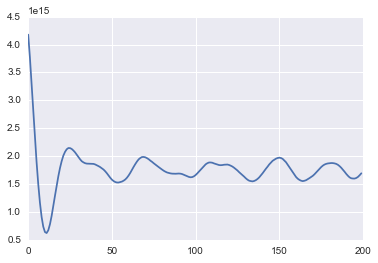

In [239]:
plt.plot(loss_history)

In [248]:
test.shape

(300000, 256)

In [249]:
test = EEG.dot(basicSpacePerceptron.transformEEG.W.data.T)
for j in range(256):
    cor_history[0,  j] = np.corrcoef(test[train_time[1]:-1, j], ECoG[train_time[1]:-1, j])[0, 1]
print(loss.data)

1691587096608768.0


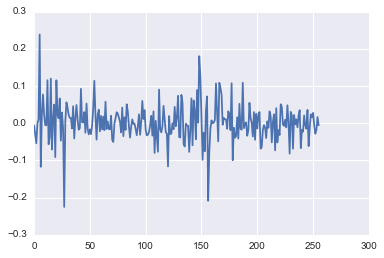

In [250]:
plt.plot(cor_history[0,])

### 時間フィルター FIR と IIR を試す

In [ ]:
# y = [y0, y1, y2, y3] 4 order までしかやらん！

y0 = model.IIR_linear()

IIR 全部バラバラ

In [452]:
b, a = signal.butter(2, [1/500 *1 , 1/500*30], 'bandpass')
bb = list(b)
bb.extend(a)
butter_filt = [bb]
butter_filt = np.array(butter_filt).astype('float32')

#w, h = signal.freqz(b, a)
#plt.plot(h)

#for ch in range(256):
#   timeSpacePerceptron.IIR_ECoG[ch].W.data = butter_filt
#for ch in range(16):
#    timeSpacePerceptron.IIR_EEG[ch].W.data = butter_filt

In [453]:
butter_filt.shape

(1, 10)

In [947]:
b, a = signal.butter(2, [1/500 *1 , 1/500*100], 'bandpass')
bb = list(b)
bb.extend(a)
butter_filt = [bb]
butter_filt = np.array(butter_filt).astype('float32')

In [ ]:
# ここは動く
class TimeSpacePerceptron(Chain):
    def __init__(self):
        self.tt = 1999
        self.eeg_num =16
        self.ecog_num = 256
        super(TimeSpacePerceptron, self).__init__(
            transformECoG = L.Linear(self.ecog_num, self.eeg_num)# ECoG to EEG 空間
            )
        for eeg_ch in range(self.eeg_num):
            super(TimeSpacePerceptron, self).add_link('IIR_EEG{0}'.format(eeg_ch), L.Linear(10, 1))
        for ecog_ch in range(self.ecog_num):
            super(TimeSpacePerceptron, self).add_link('IIR_ECoG{0}'.format(ecog_ch), L.Linear(10, 1))
        self.EEG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.eeg_num)] #前の出力をいれるところ　(RNN)
        self.ECoG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.ecog_num)] #前の出力をいれるところ
        
    def __call__(self, EEG_t, ECoG_t, train=False):
        EEG_filtered_prev = self.EEG_filtered_prev
        ECoG_filtered_prev = self.ECoG_filtered_prev
        # EEG_t は 16 * time * time_delay
        #EEG IIR
        EEG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.eeg_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(5)]
            for t in range(5):
                pre_y[t][t:] = EEG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = F.concat((EEG_t[:, ch, :], pre_y[0], pre_y[1], pre_y[2], pre_y[3], pre_y[4]))
            y = self.__dict__['IIR_EEG{0}'.format(ch)](x)
            EEG_filtered.append(y)
            EEG_filtered_prev[ch] = y
        EEG_filtered = F.concat(tuple(EEG_filtered))
        #ECoG IIR
        ECoG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.ecog_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(5)]
            for t in range(5):
                pre_y[t][t:] = ECoG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = F.concat((ECoG_t[:, ch, :], pre_y[0], pre_y[1], pre_y[2], pre_y[3], pre_y[4]))
            y = self.__dict__['IIR_ECoG{0}'.format(ch)](x)
            ECoG_filtered.append(y)
            ECoG_filtered_prev[ch] = y
        ECoG_filtered = F.concat(tuple(ECoG_filtered))
        # ここまで IIR
        ecog_space = self.transformECoG(ECoG_filtered)
        ecog_space_dropout = F.dropout(ecog_space, train=train, ratio=0.5)
        eeg  = EEG_filtered
        self.EEG_filtered_prev =EEG_filtered_prev
        self.ECoG_filtered_prev = ECoG_filtered_prev
        return ecog_space_dropout, eeg

    
#    def IIR_learn(self, data, IIRs_prev, IIR_transform):
#        #data = Variable(data.reshape((data.shape[1], data.shape[2])))
#        x = F.concat((data, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2], IIRs_prev[3], IIRs_prev[4]))
#        y= IIR_transform(x)
#        return([y, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2],IIRs_prev[3]]) # 現在の出力と過去３つの出力
    

In [969]:
# IIR をEEG, ECoG 間で共通に これはいい感じに動いた　313878.03125
class TimeSpacePerceptron(Chain):
    def __init__(self):
        self.tt = 1999
        self.eeg_num =16
        self.ecog_num = 256
        super(TimeSpacePerceptron, self).__init__(
            transformECoG = L.Linear(self.ecog_num, self.eeg_num)# ECoG to EEG 空間
            )
        super(TimeSpacePerceptron, self).add_link('IIR_EEG', L.Linear(10, 1))
        super(TimeSpacePerceptron, self).add_link('IIR_ECoG', L.Linear(10, 1))
        #for eeg_ch in range(self.eeg_num):
        #    super(TimeSpacePerceptron, self).add_link('IIR_EEG{0}'.format(eeg_ch), L.Linear(10, 1))
        #for ecog_ch in range(self.ecog_num):
        #    super(TimeSpacePerceptron, self).add_link('IIR_ECoG{0}'.format(ecog_ch), L.Linear(10, 1))
        self.EEG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.eeg_num)] #前の出力をいれるところ　(RNN)
        self.ECoG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.ecog_num)] #前の出力をいれるところ
        
    def __call__(self, EEG_t, ECoG_t, train=False):
        EEG_filtered_prev = self.EEG_filtered_prev
        ECoG_filtered_prev = self.ECoG_filtered_prev
        # EEG_t は 16 * time * time_delay
        #EEG IIR
        EEG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.eeg_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(5)]
            for t in range(5):
                pre_y[t][t:] = EEG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = F.concat((EEG_t[:, ch, :], pre_y[0], pre_y[1], pre_y[2], pre_y[3], pre_y[4]))
            y = self.__dict__['IIR_EEG'](x)
            EEG_filtered.append(y)
            EEG_filtered_prev[ch] = y
        EEG_filtered = F.concat(tuple(EEG_filtered))
        #ECoG IIR
        ECoG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.ecog_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(5)]
            for t in range(5):
                pre_y[t][t:] = ECoG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = F.concat((ECoG_t[:, ch, :], pre_y[0], pre_y[1], pre_y[2], pre_y[3], pre_y[4]))
            y = self.__dict__['IIR_ECoG'](x)
            ECoG_filtered.append(y)
            ECoG_filtered_prev[ch] = y
        ECoG_filtered = F.concat(tuple(ECoG_filtered))
        # ここまで IIR
        ecog_space = self.transformECoG(ECoG_filtered)
        ecog_space_dropout = F.dropout(ecog_space, train=train, ratio=0.5)
        eeg  = EEG_filtered
        self.EEG_filtered_prev =EEG_filtered_prev
        self.ECoG_filtered_prev = ECoG_filtered_prev
        return ecog_space_dropout, eeg

    
#    def IIR_learn(self, data, IIRs_prev, IIR_transform):
#        #data = Variable(data.reshape((data.shape[1], data.shape[2])))
#        x = F.concat((data, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2], IIRs_prev[3], IIRs_prev[4]))
#        y= IIR_transform(x)
#        return([y, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2],IIRs_prev[3]]) # 現在の出力と過去３つの出力
    

In [1003]:
# IIR をEEG, ECoG 全部で共通　9808.40625
class TimeSpacePerceptron(Chain):
    def __init__(self):
        self.tt = 1999
        self.eeg_num =16
        self.ecog_num = 256
        super(TimeSpacePerceptron, self).__init__(
            transformECoG = L.Linear(self.ecog_num, self.eeg_num)# ECoG to EEG 空間
            )
        super(TimeSpacePerceptron, self).add_link('IIR', L.Linear(10, 1))
        #for eeg_ch in range(self.eeg_num):
        #    super(TimeSpacePerceptron, self).add_link('IIR_EEG{0}'.format(eeg_ch), L.Linear(10, 1))
        #for ecog_ch in range(self.ecog_num):
        #    super(TimeSpacePerceptron, self).add_link('IIR_ECoG{0}'.format(ecog_ch), L.Linear(10, 1))
        self.EEG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.eeg_num)] #前の出力をいれるところ　(RNN)
        self.ECoG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.ecog_num)] #前の出力をいれるところ
        
    def __call__(self, EEG_t, ECoG_t, train=False):
        EEG_filtered_prev = self.EEG_filtered_prev
        ECoG_filtered_prev = self.ECoG_filtered_prev
        # EEG_t は 16 * time * time_delay
        #EEG IIR
        EEG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.eeg_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(5)]
            for t in range(5):
                pre_y[t][t:] = EEG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = F.concat((EEG_t[:, ch, :], pre_y[0], pre_y[1], pre_y[2], pre_y[3], pre_y[4]))
            y = self.__dict__['IIR'](x)
            EEG_filtered.append(y)
            EEG_filtered_prev[ch] = y
        EEG_filtered = F.concat(tuple(EEG_filtered))
        #ECoG IIR
        ECoG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.ecog_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(5)]
            for t in range(5):
                pre_y[t][t:] = ECoG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = F.concat((ECoG_t[:, ch, :], pre_y[0], pre_y[1], pre_y[2], pre_y[3], pre_y[4]))
            y = self.__dict__['IIR'](x)
            ECoG_filtered.append(y)
            ECoG_filtered_prev[ch] = y
        ECoG_filtered = F.concat(tuple(ECoG_filtered))
        # ここまで IIR
        ecog_space = self.transformECoG(ECoG_filtered)
        ecog_space_dropout = F.dropout(ecog_space, train=train, ratio=0.5)
        eeg  = EEG_filtered
        self.EEG_filtered_prev =EEG_filtered_prev
        self.ECoG_filtered_prev = ECoG_filtered_prev
        return ecog_space_dropout, eeg

    
#    def IIR_learn(self, data, IIRs_prev, IIR_transform):
#        #data = Variable(data.reshape((data.shape[1], data.shape[2])))
#        x = F.concat((data, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2], IIRs_prev[3], IIRs_prev[4]))
#        y= IIR_transform(x)
#        return([y, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2],IIRs_prev[3]]) # 現在の出力と過去３つの出力
    

In [1011]:
outout[0][-1].IIR.W.data

array([[-0.22732764,  0.04639485,  0.59046364, -0.09409814, -0.35264575,
         0.42165434,  0.11467954, -0.29644379,  0.22196496,  0.02191203]], dtype=float32)

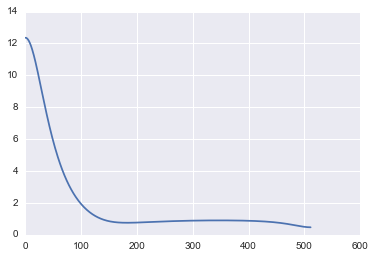

In [1015]:
w, h = signal.freqz(outout[1][-1].IIR.W.data[0][5:], outout[1][-1].IIR.W.data[0][0:5])
plt.plot(np.abs(h))

# 再構築
# 初期値を変えながら大量に実行し、同じ結果になること
# 信号をランダムに並び替えたものとの結果比較

In [1040]:
EEG_filtered, ECoG_filtered = [], []
for ch in range(EEG.shape[1]):
    tmp_sig = signal.filtfilt(outout[1][-1].IIR.W.data[0][5:], outout[1][-1].IIR.W.data[0][0:5], EEG[:, ch], axis=0)
    EEG_filtered.append(tmp_sig)
for ch in range(ECoG.shape[1]):
    tmp_sig = signal.filtfilt(outout[1][-1].IIR.W.data[0][5:], outout[1][-1].IIR.W.data[0][0:5], ECoG[:, ch], axis=0)
    ECoG_filtered.append(tmp_sig)
EEG_filtered = np.array(EEG_filtered)
ECoG_filtered = np.array(ECoG_filtered)

reconstructed_EEG = ECoG_filtered.T.dot(timeSpacePerceptron.transformECoG.W.data.T)

In [1041]:
outout[1][-1].IIR.W.data[0][5:]

array([-0.07171578,  0.4544678 , -0.00058178, -0.13215341,  0.19039367], dtype=float32)

In [1042]:
tmp_sig[-100]

nan

In [1035]:
EEG_filtered[:, -100:]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [1021]:
for i in range(16):
    print(np.corrcoef(reconstructed_EEG[:, i], EEG_filtered.T[:, i])[0, 1])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


## IIR は不安定に　FIRは？

In [13]:
order = 5
train_time = [0, 1000*2-1]
hamming = signal.hamming(train_time[1]-train_time[0])
#training ぶんだけにする
#EEG_t = np.zeros((EEG.shape[0]-order+1, EEG.shape[1], order))
#ECoG_t = np.zeros((ECoG.shape[0]-order+1, ECoG.shape[1], order))
EEG_t = np.zeros((train_time[1]-train_time[0], EEG.shape[1], order))
ECoG_t = np.zeros((train_time[1]-train_time[0], ECoG.shape[1], order))
EEG_tmp = EEG[train_time[0]:train_time[1], :] *np.array([hamming]*EEG.shape[1]).T
ECoG_tmp = ECoG[train_time[0]:train_time[1], :] *np.array([hamming]*ECoG.shape[1]).T
for t in range(order):
    for ch in range(EEG.shape[1]):
        #EEG_t[:,ch,t] = EEG[:EEG.shape[0]-order+1, ch] 
        EEG_t[t:,ch,t] = EEG_tmp[t:, ch] 
    for ch in range(ECoG.shape[1]):
        #ECoG_t[:,ch,t] = ECoG[:ECoG.shape[0]-order+1, ch] 
        ECoG_t[t:,ch,t] = ECoG_tmp[t:, ch] 
EEG_t = Variable((EEG_t[train_time[0]:train_time[1], :, :]).astype('float32'))
ECoG_t = Variable((ECoG_t[train_time[0]:train_time[1], :, :]).astype('float32'))

In [14]:
# IIR をEEG, ECoG 全部で共通　9808.40625
class TimeSpacePerceptron(Chain):
    def __init__(self):
        self.order = order
        self.tt = 1999
        self.eeg_num =16
        self.ecog_num = 256
        super(TimeSpacePerceptron, self).__init__(
            transformECoG = L.Linear(self.ecog_num, self.eeg_num)# ECoG to EEG 空間
            )
        super(TimeSpacePerceptron, self).add_link('IIR', L.Linear(self.order, 1))
        #for eeg_ch in range(self.eeg_num):
        #    super(TimeSpacePerceptron, self).add_link('IIR_EEG{0}'.format(eeg_ch), L.Linear(10, 1))
        #for ecog_ch in range(self.ecog_num):
        #    super(TimeSpacePerceptron, self).add_link('IIR_ECoG{0}'.format(ecog_ch), L.Linear(10, 1))
        self.EEG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.eeg_num)] #前の出力をいれるところ　(RNN)
        self.ECoG_filtered_prev = [Variable(np.zeros((self.tt, 1)).astype('float32')) for j in range(self.ecog_num)] #前の出力をいれるところ
        
    def __call__(self, EEG_t, ECoG_t, train=False):
        EEG_filtered_prev = self.EEG_filtered_prev
        ECoG_filtered_prev = self.ECoG_filtered_prev
        # EEG_t は 16 * time * time_delay
        #EEG IIR
        EEG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.eeg_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(self.order)]
            for t in range(self.order):
                pre_y[t][t:] = EEG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = EEG_t[:, ch, :]
            y = self.__dict__['IIR'](x)
            EEG_filtered.append(y)
            EEG_filtered_prev[ch] = y
        EEG_filtered = F.concat(tuple(EEG_filtered))
        #ECoG IIR
        ECoG_filtered = [] #  y0, y1, y2, y3, y4 が入る ch の数だけ配列
        for ch in range(self.ecog_num):
            pre_y = [np.zeros((self.tt, 1)).astype('float32') for  i in range(self.order)]
            for t in range(self.order):
                pre_y[t][t:] = ECoG_filtered_prev[ch].data[:len(pre_y[t])-t]
                pre_y[t] = Variable(pre_y[t])
            x = ECoG_t[:, ch, :]
            y = self.__dict__['IIR'](x)
            ECoG_filtered.append(y)
            ECoG_filtered_prev[ch] = y
        ECoG_filtered = F.concat(tuple(ECoG_filtered))
        # ここまで IIR
        ecog_space = self.transformECoG(ECoG_filtered)
        ecog_space_dropout = F.dropout(ecog_space, train=train, ratio=0.5)
        eeg  = EEG_filtered
        self.EEG_filtered_prev =EEG_filtered_prev
        self.ECoG_filtered_prev = ECoG_filtered_prev
        return ecog_space_dropout, eeg

    
#    def IIR_learn(self, data, IIRs_prev, IIR_transform):
#        #data = Variable(data.reshape((data.shape[1], data.shape[2])))
#        x = F.concat((data, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2], IIRs_prev[3], IIRs_prev[4]))
#        y= IIR_transform(x)
#        return([y, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2],IIRs_prev[3]]) # 現在の出力と過去３つの出力
    

In [15]:
outout = []
out_loss_history = []
for n in range(20):
    loop = 100
    out = []
    loss_history = np.zeros((loop, 1))
    st = time.time()
    timeSpacePerceptron = TimeSpacePerceptron()
    #optimizer = optimizers.RMSprop()
    optimizer = optimizers.AdaDelta()
    optimizer.setup(timeSpacePerceptron)
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.05))
    #optimizer.add_hook(chainer.optimizer.Lasso(0.5))
    optimizer.add_hook(chainer.optimizer.GradientClipping(0.5))
    #timeSpacePerceptron.zerograds()
    for i in range(loop):
        timeSpacePerceptron.zerograds()
        x1, x2 = timeSpacePerceptron(EEG_t, ECoG_t, train=True)
        loss = F.mean_squared_error(x1, x2)
        loss.backward()
        optimizer.prepare()
        optimizer.update()
        loss_history[i] = loss.data
        out.append(copy.deepcopy(timeSpacePerceptron))
    print(time.time()-st)
    print(loss.data)
    out_loss_history.append(loss_history)
    outout.append(out)

138.52205061912537
4390.90771484375
139.40174913406372
9263.453125
132.53298711776733
363.104736328125
131.74679899215698
5244.06396484375
133.4629499912262
28101794.0
132.2279496192932
12690.9072265625
137.8646957874298
3820.031005859375
135.02530646324158
27982.5625
130.27977967262268
32135.705078125
124.56816339492798
3172.5029296875
131.48776292800903
5374.91748046875
128.1611340045929
999.388671875
126.69535493850708
1120.8641357421875
124.87783646583557
1222.45556640625
125.98333954811096
16838.826171875
133.46216130256653
31057.11328125
134.31382036209106
19893.642578125
136.20396995544434
13745.3603515625
135.229017496109
717.747802734375
137.69600629806519
745.171142578125


In [ ]:
outout = []
out_loss_history = []
for n in range(20):
    loop = 100
    out = []
    loss_history = np.zeros((loop, 1))
    st = time.time()
    timeSpacePerceptron = TimeSpacePerceptron()
    #optimizer = optimizers.RMSprop()
    optimizer = optimizers.AdaDelta()
    optimizer.setup(timeSpacePerceptron)
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.05))
    #optimizer.add_hook(chainer.optimizer.Lasso(0.5))
    optimizer.add_hook(chainer.optimizer.GradientClipping(0.5))
    #timeSpacePerceptron.zerograds()
    for i in range(loop):
        timeSpacePerceptron.zerograds()
        x1, x2 = timeSpacePerceptron(EEG_t, ECoG_t, train=True)
        loss = F.mean_squared_error(x1, x2)
        loss.backward()
        optimizer.prepare()
        optimizer.update()
        loss_history[i] = loss.data
        out.append(copy.deepcopy(timeSpacePerceptron))
    print(time.time()-st)
    print(loss.data)
    out_loss_history.append(loss_history)
    outout.append(out)

6443.550512075424
12320.5419921875
6421.349303007126
9569.052734375
6415.3832948207855
30569.134765625
6414.722562074661
1010.7867431640625
6474.673071861267
1218.3746337890625
6460.043811798096
12719.6416015625
6432.408093929291

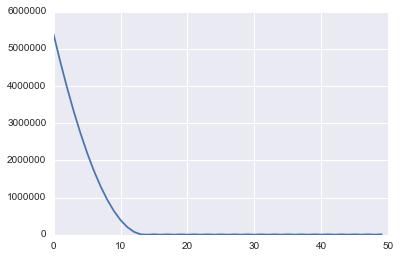

In [1094]:
plt.plot(loss_history)

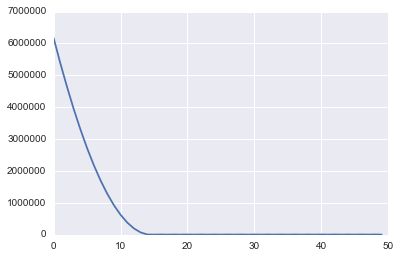

In [1104]:
plt.plot(out_loss_history[5])

In [1083]:
outout[0][-1].IIR.W.data[0]

array([ 0.31447148,  0.59061474,  0.2476957 , -0.96043068, -0.20041619], dtype=float32)

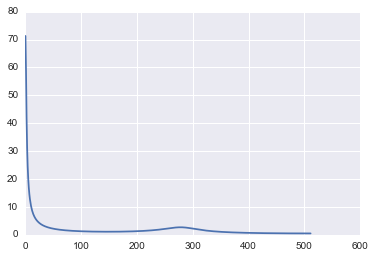

In [1105]:
w, h = signal.freqz(1, outout[5][-1].IIR.W.data[0])
plt.plot(np.abs(h))

In [1068]:
outout[1][-1].IIR.W.data[0]

array([ 0.29418254, -0.08592386, -0.23537061,  0.24182099, -0.21465771], dtype=float32)

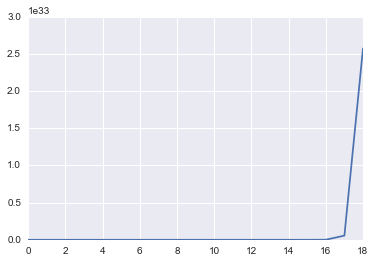

In [1000]:
plt.plot(loss_history)

In [1001]:
from scipy import signal
w, h = signal.freqz(out[-1].IIR.W.data[0][5:], out[-1].IIR.W.data[0][0:5])

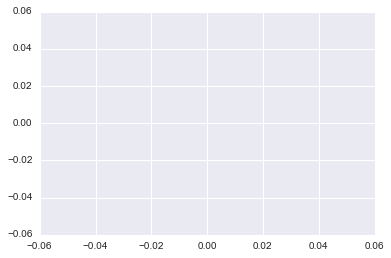

In [1002]:
plt.plot(np.abs(h))

In [975]:
out[-1].IIR_EEG0.W.data 

AttributeError: 'TimeSpacePerceptron' object has no attribute 'IIR_EEG0'

In [ ]:
out[0].IIR_EEG1.W.data - out[1].IIR_EEG1.W.data

In [ ]:
out[0].IIR_ECoG0.W.data - out[1].IIR_ECoG0.W.data

In [ ]:
out[0].transformECoG.W.data - out[1].transformECoG.W.data

In [ ]:
out[-1].IIR_EEG0.W.data

## フィルター復元

In [307]:
EEG_filtered, ECoG_filtered = [], []
for ch in range(EEG.shape[1]):
    tmp_sig = signal.lfilter(timeSpacePerceptron.IIR_EEG[ch].W.data[0][4:7], timeSpacePerceptron.IIR_EEG[ch].W.data[0][0:3], EEG[:, ch])
    EEG_filtered.append(tmp_sig)
for ch in range(ECoG.shape[1]):
    tmp_sig = signal.lfilter(timeSpacePerceptron.IIR_ECoG[ch].W.data[0][4:7], timeSpacePerceptron.IIR_ECoG[ch].W.data[0][0:3], ECoG[:, ch])
    ECoG_filtered.append(tmp_sig)
EEG_filtered = np.array(EEG_filtered)
ECoG_filtered = np.array(ECoG_filtered)

reconstructed_ECoG = EEG_filtered.T.dot(timeSpacePerceptron.transformEEG.W.data.T)

In [308]:
tmp = []
for ch in range(256):
    tmp.append(np.corrcoef(reconstructed_ECoG.T[ch,:], ECoG_filtered[ch, :])[0,1])

/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/numpy/lib/function_base.py:953: RuntimeWarning: invalid value encountered in multiply
  scl = np.multiply(avg, 0) + scl
/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/numpy/lib/function_base.py:2479: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [298]:
np.sum(np.isnan(ECoG_filtered[255, :]))

299151

In [474]:
class common_TimeSpacePerceptron(Chain): # IIR がみんな同じ
    def __init__(self):
        tt = 999
        super(common_TimeSpacePerceptron, self).__init__(
            transformEEG = L.Linear(16, 256)# EEG 空間
            )
        self.IIR = L.Linear(7, 1)
        self.EEG_IIRs_prev = [[Variable(np.zeros((tt, 1)).astype('float32')) for i in range(4)] for j in range(16)] #前の出力をいれるところ　(RNN)
        self.ECoG_IIRs_prev = [[Variable(np.zeros((tt, 1)).astype('float32')) for i in range(4)] for j in range(256)] #前の出力をいれるところ
        
    def __call__(self, EEG_t, ECoG_t, train=False):
        EEG_IIRs_prev = self.EEG_IIRs_prev
        ECoG_IIRs_prev = self.ECoG_IIRs_prev
        # EEG_t は 16 * time * time_delay
        EEG_IIRs = [] #  y0, y1, y2, y3 が入る ch の数だけ配列
        for ch in range(EEG_t.data.shape[1]):
            EEG_IIRs.append(self.IIR_learn(EEG_t[:, ch, :], EEG_IIRs_prev[ch], self.IIR))
        ECoG_IIRs = [] #  y0, y1, y2, y3 が入る ch の数だけ配列
        for ch in range(ECoG_t.data.shape[1]):
            ECoG_IIRs.append(self.IIR_learn(ECoG_t[:, ch, :], ECoG_IIRs_prev[ch], self.IIR))
        EEG_filtered, ECoG_filtered = [], []
        for ch in range(EEG_t.data.shape[1]):
            EEG_filtered.append(EEG_IIRs[ch][0])
        EEG_filtered = F.concat(tuple(EEG_filtered))
        for ch in range(ECoG_t.data.shape[1]):
            ECoG_filtered.append(ECoG_IIRs[ch][0])
        ECoG_filtered = F.concat(tuple(ECoG_filtered))
        # ここまで IIR
        eeg_space = self.transformEEG(EEG_filtered)
        eeg_space_dropout = F.dropout(eeg_space, train=train, ratio=0.5)
        ecog  = ECoG_filtered
        y = eeg_space_dropout - ecog
        self.EEG_IIRs_prev = EEG_IIRs
        self.ECoG_IIRs_prev = ECoG_IIRs
        return eeg_space_dropout, ecog
    
    def IIR_learn(self, data, IIRs_prev, IIR_transform):
        #data = Variable(data.reshape((data.shape[1], data.shape[2])))
        x = F.concat((data, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2]))
        y= IIR_transform(x)
        return([y, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2]]) # 現在の出力と過去３つの出力
    

In [475]:
timeSpacePerceptron = common_TimeSpacePerceptron()
optimizer = optimizers.AdaDelta()
optimizer.setup(timeSpacePerceptron)
optimizer.weight_decay(0.0005)
timeSpacePerceptron.zerograds()

In [476]:
loop = 3
loss_history = np.zeros((loop, 1))
st = time.time()
EEG_t = np.zeros((EEG.shape[0]-3, EEG.shape[1], 4))
ECoG_t = np.zeros((ECoG.shape[0]-3, ECoG.shape[1], 4))
train_time = [0, 1000*1-1]
for t in range(4):
    for ch in range(EEG.shape[1]):
        EEG_t[:,ch,t] = EEG[t:EEG.shape[0]-3+t, ch]
    for ch in range(ECoG.shape[1]):
        ECoG_t[:,ch,t] = ECoG[t:ECoG.shape[0]-3+t, ch]
EEG_t = Variable(EEG_t[train_time[0]:train_time[1], :, :].astype('float32'))
ECoG_t = Variable(ECoG_t[train_time[0]:train_time[1], :, :].astype('float32'))
for i in range(loop):
    x1, x2 = timeSpacePerceptron(EEG_t, ECoG_t, train=True)
    loss = F.mean_squared_error(x1, x2)
    loss.backward()
    optimizer.update()
    loss_history[i] = loss.data
print(time.time()-st)
print(loss.data)

14.419137001037598
24934920.0


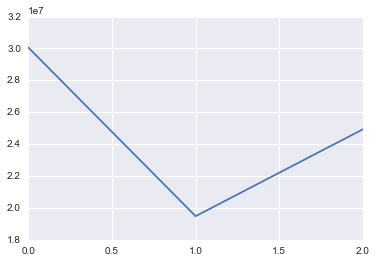

In [477]:
plt.plot(loss_history)

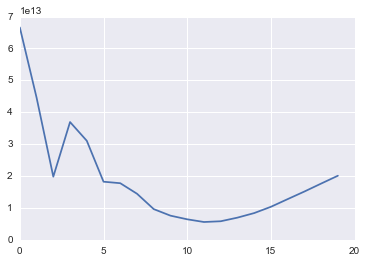

In [347]:
plt.plot(loss_history)

In [300]:
class FIR_TimeSpacePerceptron(Chain):
    def __init__(self):
        tt = 59999
        super(TimeSpacePerceptron, self).__init__(
            transformEEG = L.Linear(17, 256)# EEG 空間
            )
        self.FIR_EEG = [L.Linear(7, 1) for i in range(16)] , #copy されているかは要チェック
        self.FIR_ECoG = [L.Linear(7, 1)] * 256
        
    def __call__(self, EEG_t, ECoG_t, train=False):
        EEG_FIRs = [] #  ch の数だけ配列
        for ch in range(EEG_t.data.shape[1]):
            EEG_FIRs.append(self.FIR_learn(EEG_t[:, ch, :], self.FIR_EEG[ch]))
        ECoG_FIRs = [] #  ch の数だけ配列
        for ch in range(ECoG_t.data.shape[1]):
            ECoG_FIRs.append(self.IIR_learn(ECoG_t[:, ch, :], self.FIR_ECoG[ch]))
        EEG_filtered, ECoG_filtered = [], []
        for ch in range(EEG_t.data.shape[1]):
            EEG_filtered.append(EEG_FIRs[ch][0])
        EEG_filtered = F.concat(tuple(EEG_filtered))
        for ch in range(ECoG_t.data.shape[1]):
            ECoG_filtered.append(ECoG_FIRs[ch][0])
        ECoG_filtered = F.concat(tuple(ECoG_filtered))
        EEG_filtered = FIR_learn(EEG_t)
        eeg_space = self.transformEEG(EEG_filtered)
        eeg_space_dropout = F.dropout(eeg_space, train=train, ratio=0.5)
        ecog  = ECoG_filtered
        y = eeg_space_dropout - ecog
        return y
    
    def FIR_learn(self, data, IIR_transform):
        #data = Variable(data.reshape((data.shape[1], data.shape[2])))
        #x = F.concat((data, IIRs_prev[0], IIRs_prev[1], IIRs_prev[2]))
        x = data
        y= IIR_transform(x)
        return y

In [ ]:
fir_timeSpacePerceptron = FIR_TimeSpacePerceptron()
optimizer = optimizers.AdaDelta()
optimizer.setup(fir_timeSpacePerceptron)
optimizer.weight_decay(0.0005)

In [ ]:
fir_timeSpacePerceptron.zerograds()
loop = 3
cor_history = np.zeros((loop, 256))
loss_history = np.zeros((loop, 1))
st = time.time()
EEG_t = np.zeros((EEG.shape[0]-3, EEG.shape[1], 4))
ECoG_t = np.zeros((ECoG.shape[0]-3, ECoG.shape[1], 4))
train_time = [0, 1000*60-1]
for t in range(4):
    for ch in range(EEG.shape[1]):
        EEG_t[:,ch,t] = EEG[t:EEG.shape[0]-3+t, ch]
    for ch in range(ECoG.shape[1]):
        ECoG_t[:,ch,t] = ECoG[t:ECoG.shape[0]-3+t, ch]
EEG_t = Variable(EEG_t[train_time[0]:train_time[1], :, :].astype('float32'))
ECoG_t = Variable(ECoG_t[train_time[0]:train_time[1], :, :].astype('float32'))
for i in range(loop):
    loss = F.sum(fir_timeSpacePerceptron(EEG_t, ECoG_t, train=True) **2)
    loss.backward()
    optimizer.update()
    loss_history[i] = loss.data
    print(time.time()-st)
    print(loss.data)